In [1]:
from metaflow import Metaflow, Run, Flow, get_metadata, namespace, Step, Task
import pandas as pd
import numpy as np

from plotnine import ggplot, geom_histogram, aes, theme_set, theme_bw, xlab, ylab, scales
theme_set(theme_bw())

plots = {}

import os
if not os.path.exists('out'):
    os.makedirs('out')

print("Current metadata provider: %s" % get_metadata())

Current metadata provider: local@/home/jakob/Code/python/python_projects/2021-05-05 Welfords Algorithm Analysis


## Access Results from Metaflow Metadata Store

In [2]:
# identify run to analyse
for r in [rr for rr in list(Flow('WelfordSimFlow').runs()) if rr.successful]:
    print("Run '{}' finished {}".format(r.id, r.finished_at))

Run '1620241516973706' finished 2021-05-05T19:41:08Z


In [3]:
run_to_analyse = Run('WelfordSimFlow/1620241516973706')
results_simulation = run_to_analyse.data.data_variances_combined
datasets_simulation = run_to_analyse.data.datasets

## Post-Process data


In [4]:
# shift variance estimates by minimal amount so all errors can be computed
results_simulation['var_numpy'] = results_simulation['var_numpy'] + 1e-20
results_simulation['var_welford'] = results_simulation['var_welford'] + 1e-20

In [5]:
results_simulation['abs_error'] = abs(results_simulation['var_numpy'] - results_simulation['var_welford'])
results_simulation['rel_error'] = results_simulation['abs_error']/results_simulation['var_numpy'] + 1e-20

In [6]:
results_simulation

,row_id,value,count_welford,mean_welford,M2_welford,var_welford,column,var_numpy,dataset_id,abs_error,rel_error
282,282,0.000000,283.0,1.236749e-01,30.671378,1.087638e-01,FCFP6_1024_36,1.087638e-01,3963,4.163336e-17,3.827971e-16
282,282,0.000000,283.0,7.067138e-03,1.985866,7.042077e-03,FCFP6_1024_869,7.042077e-03,3963,2.602085e-18,3.695154e-16
282,282,0.000000,283.0,0.000000e+00,0.000000,1.000000e-20,FCFP6_1024_146,1.000000e-20,3963,0.000000e+00,1.000000e-20
282,282,0.000000,283.0,0.000000e+00,0.000000,1.000000e-20,FCFP6_1024_349,1.000000e-20,3963,0.000000e+00,1.000000e-20
282,282,0.000000,283.0,2.650177e-01,55.123675,1.954740e-01,FCFP6_1024_883,1.954740e-01,3963,8.326673e-17,4.259834e-16
...,...,...,...,...,...,...,...,...,...,...,...
999,999,0.881283,1000.0,2.137000e-10,998.999998,1.000000e+00,oz22,1.000000e+00,589,0.000000e+00,1.000000e-20
999,999,-1.020728,1000.0,6.125000e-11,999.000004,1.000000e+00,oz10,1.000000e+00,589,6.661338e-16,6.661438e-16
999,999,-0.766837,1000.0,8.812000e-10,998.999998,1.000000e+00,oz9,1.000000e+00,589,1.887379e-15,1.887389e-15
999,999,0.078042,1000.0,-4.419000e-11,999.000003,1.000000e+00,oz20,1.000000e+00,589,2.220446e-16,2.220546e-16


## Statistics About Datasets Used in Simulation

In [7]:
print("Number of datasets in simulation: {0}".format(len(datasets_simulation['did'].unique())))
print("Minimum number of observations per dataset: {0}".format(int(datasets_simulation['NumberOfInstances'].min())))
print("Maximum number of observations per dataset: {0}".format(int(datasets_simulation['NumberOfInstances'].max())))
print("Median number of observations per dataset: {0}".format(int(datasets_simulation['NumberOfInstances'].median())))

Number of datasets in simulation: 500
Minimum number of observations per dataset: 2
Maximum number of observations per dataset: 4898431
Median number of observations per dataset: 400


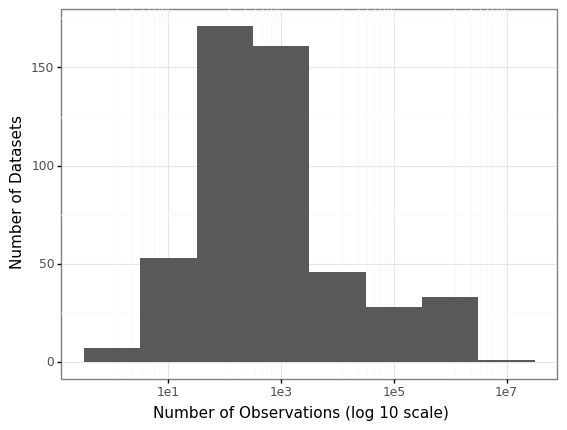

<ggplot: (8736680112312)>

In [8]:
plots['dist_obs_dataset'] = (ggplot(datasets_simulation, aes('NumberOfInstances'))
 + geom_histogram(binwidth = 1) 
 + xlab("Number of Observations (log 10 scale)") 
 + ylab("Number of Datasets")
 + scales.scale_x_log10())
plots['dist_obs_dataset']

## Analysis of Results

In [9]:
print("Number of variances computed: {}".format(len(results_simulation)))
print("Maximum relative error: {}".format(results_simulation['rel_error'].max()))
print("Mean relative error: {}".format(results_simulation['rel_error'].mean()))
print("Median relative error: {}".format(results_simulation['rel_error'].median()))
print("Percentage of cases with exact matches: {}".format(np.mean(results_simulation['rel_error'] <= 1e-20)))

Number of variances computed: 7935
Maximum relative error: 2.238899973785924e-07
Mean relative error: 4.900202088594697e-10
Median relative error: 2.920710794339982e-16
Percentage of cases with exact matches: 0.30107120352867045


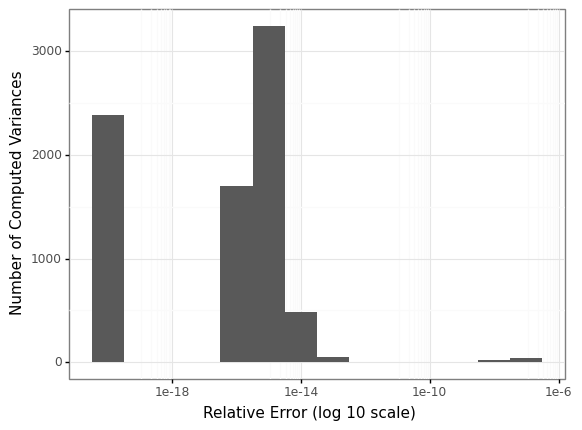

<ggplot: (8736677880483)>

In [10]:
plots['dist_rel_error'] = (ggplot(results_simulation, aes('rel_error'))
 + geom_histogram(binwidth = 1) 
 + xlab("Relative Error (log 10 scale)") 
 + ylab("Number of Computed Variances")
 + scales.scale_x_log10())
plots['dist_rel_error']

## Write out Plots

In [12]:
for k,v in plots.items():
    v.save(filename = "out/" + k + ".png",width = 12, height = 10)

/home/jakob/.conda/envs/welford_py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 10 in image.
/home/jakob/.conda/envs/welford_py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: out/dist_obs_dataset.png
/home/jakob/.conda/envs/welford_py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 10 in image.
/home/jakob/.conda/envs/welford_py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: out/dist_rel_error.png
